# Проект "Прогнозирование оттока клиентов"

## Общая информация

### Установка сторонних библиотек

In [5]:
!pip install phik
!pip install seaborn 
!pip install matplotlib
!pip install catboost

     ---------------------------------------- 0.0/663.4 kB ? eta -:--:--
      --------------------------------------- 10.2/663.4 kB ? eta -:--:--
     - ----------------------------------- 30.7/663.4 kB 435.7 kB/s eta 0:00:02
     --- --------------------------------- 61.4/663.4 kB 544.7 kB/s eta 0:00:02
     ----------- -------------------------- 204.8/663.4 kB 1.4 MB/s eta 0:00:01
     ----------------------- -------------- 409.6/663.4 kB 2.1 MB/s eta 0:00:01
     -------------------------------------  655.4/663.4 kB 2.9 MB/s eta 0:00:01
     -------------------------------------- 663.4/663.4 kB 2.5 MB/s eta 0:00:00
  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/63/379617e3d982e8a66c9d66ebf4621d3357c7c18ad356473c335bffd5aba6/catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     -------- ------------------------------- 10.2/47.0 kB ? eta -:--:--
     -------------

### Импорт библиотек

In [6]:
#импорты из стандартной библиотеки
import warnings
from functools import reduce

#импорты сторонних библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#импорты модулей текущего проекта
from catboost import CatBoostClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score, 
    roc_curve
)    
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

#настройки
warnings.filterwarnings("ignore")

#константы заглавными буквами
RANDOM_STATE = 310723

### Загрузка датасетов

In [7]:
try:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv('datasets/contract_new.csv')
    personal = pd.read_csv('datasets/personal_new.csv')
    internet = pd.read_csv('datasets/internet_new.csv')
    phone = pd.read_csv('datasets/phone_new.csv')

In [8]:
def get_data_info(data):
    display(data.info())
    display(data.head())
    display(data.describe())
    try:
        display(data.hist())
    except:
        print('Nothing to plot!')

### Таблица '**contract**'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


array([[<Axes: title={'center': 'MonthlyCharges'}>]], dtype=object)

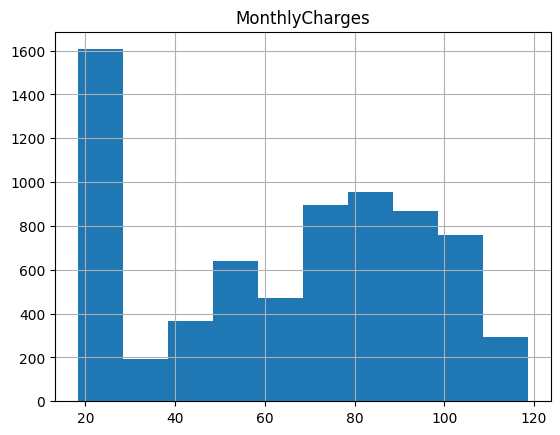

In [9]:
get_data_info(contract)

- В таблице '**contract**' находятся 7043 строчки и 8 столбцов с информацией о контрактах клиентов с оператором связи. Пропусков в данных нет.
- Также в ней располагается целевой признак (**EndDate**). В дальнейшем мы несколько изменим его форму для более удобной работы.
- Среднее значение ежемесячных сборов составляет **65**.
- Гистограмма была построена только по одному из двух числовых столбцов. Во время предобработки все недочёты подобного рода будут устранены.

### Таблица '**personal**'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


array([[<Axes: title={'center': 'SeniorCitizen'}>]], dtype=object)

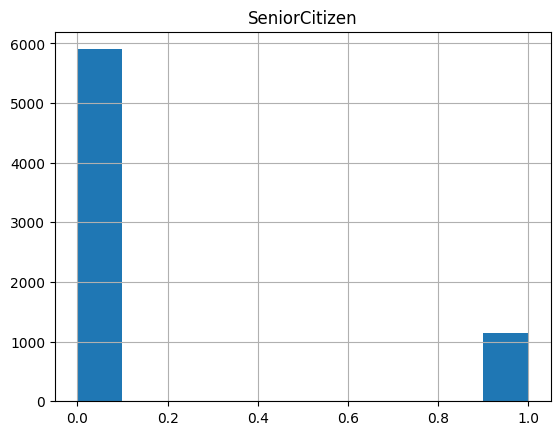

In [10]:
get_data_info(personal)

- В таблице '**personal**' находятся 7043 строчки и 5 столбцов с личной информацией о клиентах. Пропусков в данных нет.
- Мы знаем факты о **поле**, **возрасте** (пенсионный или нет), **наличии партнера**, **наличии детей** (иждивенцев).
- Гистограмма показывает, что **~1100** человек - это пенсионеры.

### Таблица '**internet**'

In [11]:
get_data_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Nothing to plot!


- В таблице '**internet**' находятся 5517 строчки и 8 столбцов с информацией об интернет услугах клиентов. Пропусков в данных нет.
- В каждом столбце, кроме **ID клиента** по 2 уникальных значения.
- Числовых столбцов нет, поэтому нет и гистограммы.
- При дальнейшем объединении датасетов в столбцах датасета **internet** будет много пропусков. Их нужно будет заменить **иными значениями**, или **нулями, если услуга не предоставляется**.

### Таблица '**phone**'

In [12]:
get_data_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Nothing to plot!


- В таблице '**phone**' находятся 6361 строчка и 2 столбца с информацией о телефонных услугах клиентов. Пропусков в данных нет, а вот их **тип нужно будет поменять**.
- Также, как и в предыдущих данных, далее в стобце **MultipleLines** будет много пропусков. Их нужно будет заполнить **значением 'No'**, так как, скорее всего, если ID клиента здесь не указано, то этой услугой он не пользуется..

## Предобработка данных

Прежде чем начинать работу с данными нам следует объединить их в одну таблицу **df_all**. Сделаем это, используя метод **merge**.

In [13]:
data_frames = [contract, personal, internet, phone]
df_all = reduce(lambda  left, right: pd.merge(left, right, on=['customerID'], 
                                                 how='left'), data_frames)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


В полном датафрейме целых **20 столбцов**! \
Теперь пора изменить типы, разобраться с пропусками и аномалиями, а затем создать новые признаки.

### Приведение данных к нужным типам

In [14]:
df_all.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
dtype: object

In [15]:
df_all.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


По общей информации о датасете и первым нескольким строчкам установим, в каких столбцах поменять типы данных:
- BeginDate -> **datetime**
- TotalCharges-> **float**

Остальные столбцы оставим как есть. Многие из них содержат в себе всего по 2 уникальных значения: 'Yes' и 'No'. Мы могли бы заменить их на '0' и '1', но делать этого не будем.

In [16]:
df_all['BeginDate'] = pd.to_datetime(df_all['BeginDate'])
df_all['BeginDate'].head(3)

0   2020-01-01
1   2017-04-01
2   2019-10-01
Name: BeginDate, dtype: datetime64[ns]

Чтобы корректно обработать столбец **TotalCharges** нужно обработать строки, содержащие пробел. Всего их столько:

In [17]:
df_all[df_all['TotalCharges'] == ' ']['TotalCharges'].count()

11

In [18]:
df_all['TotalCharges'] = np.where(df_all['TotalCharges'] == ' ', '0', df_all['TotalCharges'])

Теперь выполним замену:

In [19]:
df_all['TotalCharges'] = pd.to_numeric(df_all['TotalCharges'], downcast="float")

Проверим результат:

In [20]:
df_all.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float32
gender                      object
SeniorCitizen                int64
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
dtype: object

Перейдём к пропускам и дубликатам.

### Удаление дубликатов и заполнение пропусков.

##### Дубликаты

In [21]:
df_all.duplicated().sum()

0

Их в данных нет.

##### Пропуски

Выведем количество пропущенных значений в каждом столбце:

In [22]:
df_all.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Как и ожидалось, пропуски есть только в столбцах, которые были в файлах **internet** и **phone**. \
Попробуем понять, что с ними делать.

В столбце **InternetService** указаны не просто 'Yes' или 'No', а конкретные категории: **DSL**, **Fiber optic**.

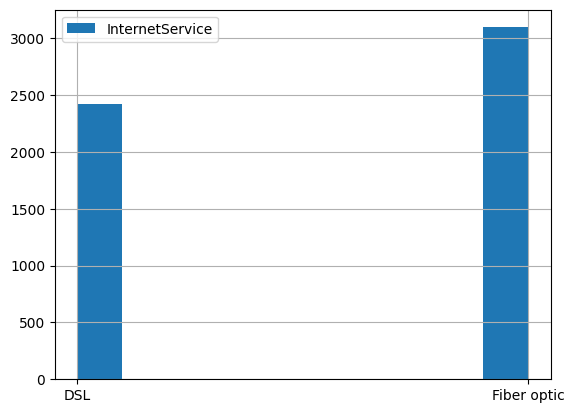

In [23]:
df_all['InternetService'].hist(legend=True);

В случае с этим столбцом мы не можем использовать для заполнения одно из этих значений. Поэтому создадим отдельную группу **Other**.

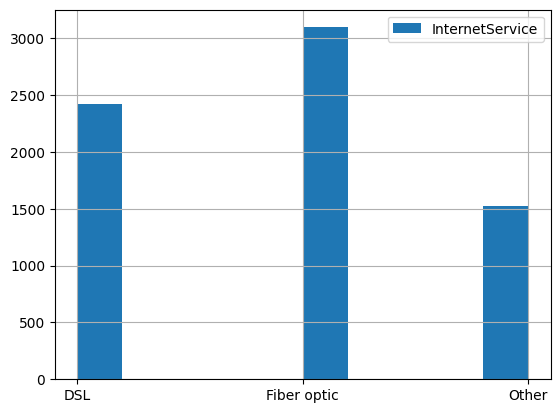

In [24]:
df_all['InternetService'].fillna('Other', inplace=True)
df_all['InternetService'].hist(legend=True);

Далее все столбцы содержат только значения **'да-нет'**. Можно предположить, что если клиент не был указан в таблицах **internet** или **phone**, то он этими услугами не пользуется. Поэтому пропуски заменим на **'No'**.

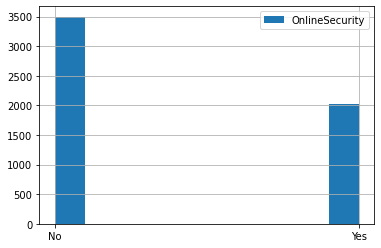

In [23]:
df_all['OnlineSecurity'].hist(legend=True);

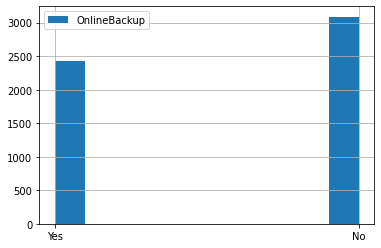

In [24]:
df_all['OnlineBackup'].hist(legend=True);

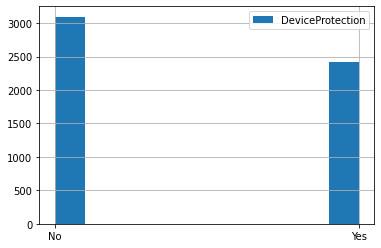

In [25]:
df_all['DeviceProtection'].hist(legend=True);

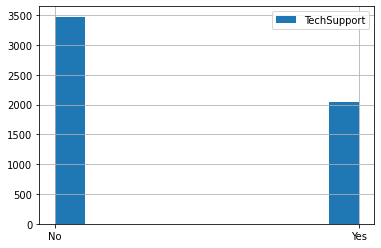

In [26]:
df_all['TechSupport'].hist(legend=True);

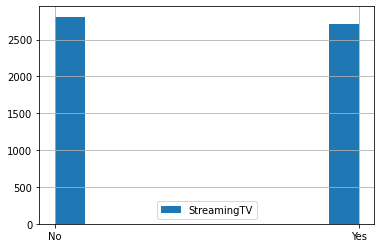

In [27]:
df_all['StreamingTV'].hist(legend=True);

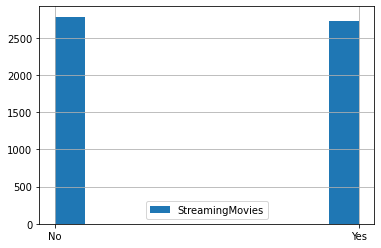

In [28]:
df_all['StreamingMovies'].hist(legend=True);

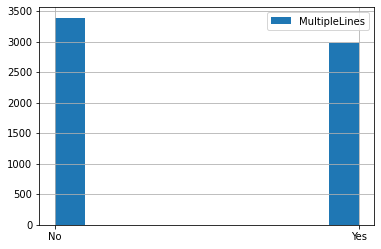

In [29]:
df_all['MultipleLines'].hist(legend=True);

Приведенные выше гистограммы показывают, что большая часть людей не пользуется этими услугами. Значит можно быть уверенными, что мы никого не потеряем при замене.

In [30]:
services = np.array(df_all.columns)[13:]
services

array(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype=object)

In [31]:
df_all.loc[:, services] = df_all.loc[:, services].fillna('No')

Проверим пропуски ещё раз:

In [32]:
df_all.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Их не осталось! \
Перейдём к аномалиям.

### Анализ аномальных значений

Создадим функцию, которая покажет уникальные элементы столбцов:

In [33]:
for column in np.array(df_all.columns):
    print(column)
    print(df_all[column].unique())
    print()

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

BeginDate
['2020-01-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2018-04-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2019-01-01T00:00:00.000000000' '2018-10-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2015-10-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2016-01-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2017-11-01T00:

Рассмотрим поближе количественные столбцы: **MonthlyCharges** и **TotalCharges**.

In [34]:
df_all['MonthlyCharges'].sort_values()

3719     18.25
1529     18.40
6652     18.55
6906     18.70
1156     18.70
         ...  
5127    118.35
3894    118.60
4804    118.60
2115    118.65
4586    118.75
Name: MonthlyCharges, Length: 7043, dtype: float64

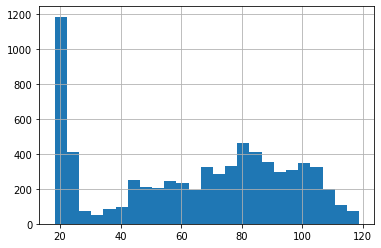

In [35]:
df_all['MonthlyCharges'].hist(bins=25);

С ежемесячными сборами всё хорошо, большая часть клиентов платят за связь **около 20** денежных единиц в месяц. 

In [36]:
df_all['TotalCharges'].sort_values()

3826       0.000000
4380       0.000000
1082       0.000000
6670       0.000000
936        0.000000
           ...     
540     8957.519531
4206    8998.269531
2559    9068.360352
5558    9218.879883
4610    9221.379883
Name: TotalCharges, Length: 7043, dtype: float32

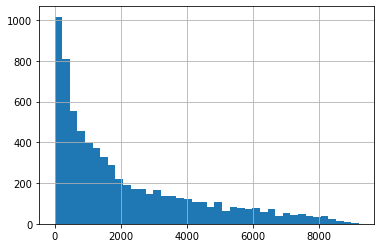

In [37]:
df_all['TotalCharges'].hist(bins=40);

А вот с общей суммой сборов всё сложнее. Слишком много случаев около нуля. Рассмотрим детальнее:

In [38]:
df_all.query('TotalCharges < 1000').shape

(2965, 20)

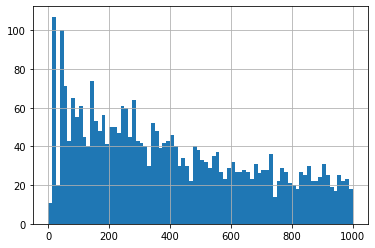

In [39]:
df_all.query('TotalCharges < 1000')['TotalCharges'].hist(bins=80);

Почти половина клиентов заплатили **менее 1000**. Сузим диапазон.

In [40]:
df_all.query('TotalCharges < 100').shape

(472, 20)

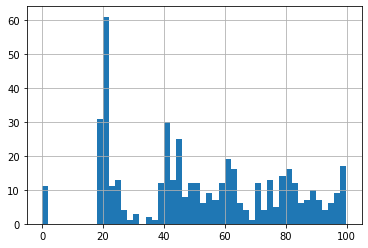

In [41]:
df_all.query('TotalCharges < 100')['TotalCharges'].hist(bins=50);

Вот и подозрительные нули.

In [42]:
df_all.query('TotalCharges < 10')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0,Male,0,No,Yes,Other,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0,Male,0,Yes,Yes,Other,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0,Male,0,Yes,Yes,Other,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0,Male,0,Yes,Yes,Other,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0,Female,0,Yes,Yes,Other,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0,Male,0,Yes,Yes,Other,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Но оказывается всё в порядке. Эти 11 человек начали пользоваться услугами связи в день выгрузки датасета **1 февраля 2020 года**. \
Перейдём к самым большим значениям.

In [43]:
df_all.query('TotalCharges > 8000')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
17,9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,8257.509766,Male,0,No,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes
198,7255-SSFBC,2014-02-01,No,Two year,Yes,Bank transfer (automatic),112.25,8324.459961,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
369,3520-FJGCV,2014-02-01,No,Two year,Yes,Credit card (automatic),112.60,8755.780273,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
437,4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.599609,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
464,1480-BKXGA,2014-02-01,No,Two year,Yes,Bank transfer (automatic),116.05,8355.599609,Male,1,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6700,8107-RZLNV,2014-02-01,No,Two year,Yes,Bank transfer (automatic),106.30,8342.419922,Male,0,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
6728,2380-DAMQP,2014-02-01,No,Two year,No,Electronic check,115.15,8788.250000,Female,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6768,9739-JLPQJ,2014-02-01,No,Two year,No,Credit card (automatic),117.50,8713.799805,Female,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6910,0530-IJVDB,2014-04-01,No,Two year,Yes,Electronic check,114.60,8182.439941,Male,0,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes


Тут тоже всё законно: давно пользуются услугами и много платят каждый месяц, поэтому и общая сумма высокая. \
Аномалий нет!

### Генерация признаков

В этом проекте мы решаем задачу классификации клиентов на лояльных и отточных. Но как используя то, что мы имеем, определить класс, к которому принадлежит тот или иной клиент? \
В этом вопросе нам помогут столбцы **BeginDate** и **EndDate**. Основываясь на дате ухода или её отсутствия создадим **целевой признак**. А из даты начала действия контракта мы получим **количество дней**, которые пользователь провёл вместе с нашим сотовым оператором.

In [44]:
df_all['leaving'] = np.where(df_all['EndDate'] == 'No', 0, 1)
df_all.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,leaving
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.840088,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0


In [45]:
def duration(row):
    if row['EndDate'] == 'No':
        return pd.to_datetime('2020-02-01') - row['BeginDate']
    else:
        return pd.to_datetime(row['EndDate']) - row['BeginDate']

In [46]:
df_all['duration'] = df_all.apply(duration, axis=1).dt.days
df_all.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,leaving,duration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.840088,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123


Два новых признака успешно добавлены в таблицу! \
На этом **преобработка завершена**. Перейдём к **исследовательскому анализу данных**.

## Исследовательский анализ данных

Попробуем сделать дополнительные выводы о данных, более подробно исследовав группы клиентов. 

### Лояльные клиенты

Начнём с тех людей, которые всё ещё пользуются услугами компании.

In [47]:
loyal = df_all.query('leaving == 0')
print(f'Процент лояльных клиентов на момент выгрузки данных: {round(loyal.shape[0] / df_all.shape[0] * 100)}%')

Процент лояльных клиентов на момент выгрузки данных: 84%


Как видно, к 2020 году оператор потерял лишь 16% пользователей.  

In [48]:
df_all['BeginDate'].min().year

2013

Учитывая то, что первый контракт заключён в 2013 году, результат неплохой. Но это число всё равно хотелось бы сократить. \
Взглянем на данные, а именно на **использование услуг клиентами**:

In [49]:
def service_use(data, show=True):
    use_of_services = []
    for service in services:
        statistics = data[service].value_counts()
        percentage = round(statistics[1] / data.shape[0] * 100)
        use_of_services.append(percentage)
        if show:
            print(f'Услугой {service} пользуется {percentage}% лояльных клиентов')
    return use_of_services

In [50]:
loyal_services = service_use(loyal, False)

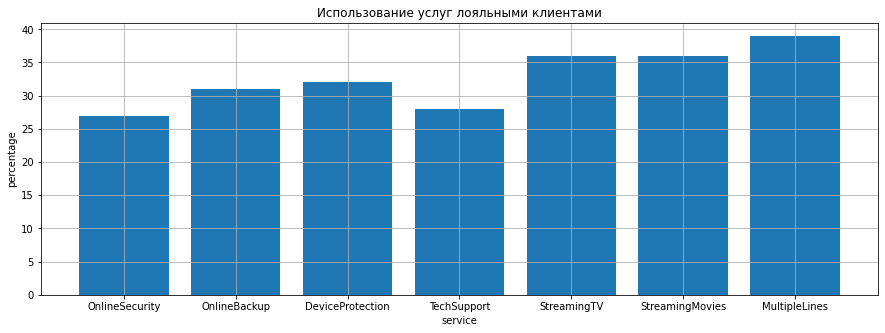

In [51]:
fig = plt.figure(figsize = (15, 5))

plt.bar(services, loyal_services)

plt.title("Использование услуг лояльными клиентами")

plt.xlabel('service')
plt.ylabel('percentage')
plt.grid(True)
 
plt.show()

Для необязательных сервисов результат очень хороший! Самые востребованные из них **тв**, **кино** и **мнококанальность для телефона**. \
Рассмотрим персональные данные:

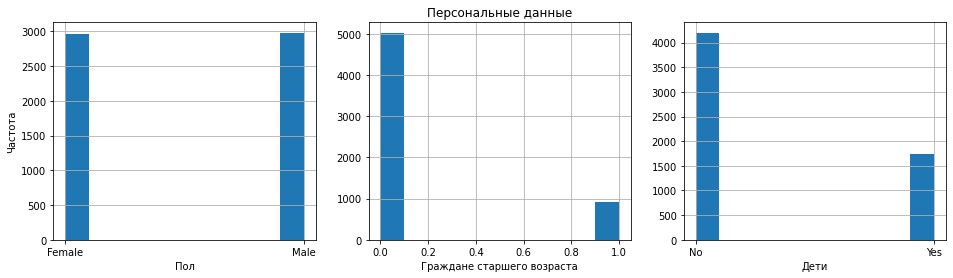

In [52]:
plt.figure(figsize=(16, 4))


plt.subplot(131)
plt.grid(True)
plt.xlabel('Пол')
plt.ylabel('Частота')
plt.hist(loyal['gender'])


plt.subplot(132)
plt.grid(True)
plt.xlabel('Граждане старшего возраста')
# plt.ylabel('Частота')
plt.hist(loyal['SeniorCitizen'])

plt.title('Персональные данные')

plt.subplot(133)
plt.grid(True)
plt.xlabel('Дети')
# plt.ylabel('Частота')
plt.hist(loyal['Dependents'])

plt.show()

**Мужчины и женщины разделены** ровно **пополам**, пенсионеров **чуть меньше 1000**, а клиентов без детей в **~2,5 раза** больше, чем с детьми. \
Теперь проанализируем длительность пользования услугами в сравнении с типом контракта:

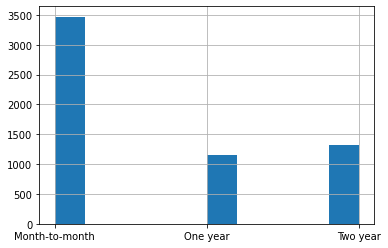

In [53]:
loyal['Type'].hist();

Месячные договоры **гораздо популярнее** годовых или 2-х годовых. 

In [54]:
loyal.groupby(['Type'])['duration'].mean()

Type
Month-to-month     500.477797
One year          1193.392241
Two year          1666.865297
Name: duration, dtype: float64

Однако чем выше срок действия контракта, тем выше средняя длительность пользования. Разберёмся что к чему.

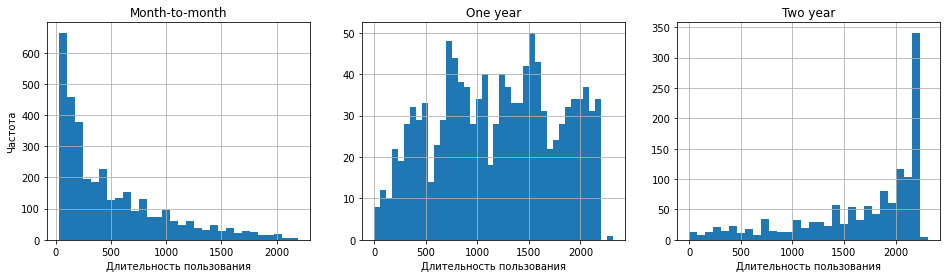

In [55]:
plt.figure(figsize=(16, 4))


plt.subplot(131)
plt.grid(True)
plt.title('Month-to-month')
plt.xlabel('Длительность пользования')
plt.ylabel('Частота')
plt.hist(loyal.query('Type == "Month-to-month"')['duration'], bins=30)

plt.subplot(132)
plt.grid(True)
plt.title('One year')
plt.xlabel('Длительность пользования')
# plt.ylabel('Частота')
plt.hist(loyal.query('Type == "One year"')['duration'], bins=40)

plt.subplot(133)
plt.grid(True)
plt.title('Two year')
plt.xlabel('Длительность пользования')
# plt.ylabel('Частота')
plt.hist(loyal.query('Type == "Two year"')['duration'], bins=30)

plt.show()

- **Месяц**: много новых пользователей, но мало постоянных.
- **Год**: одинаково для каждого срока.
- **Два года**: мало новых клиентов, много постоянных.

Для лояльных клиентов все важные признаки мы рассмотрели. \
Перейдём к отточным.

### Отточные клиенты

In [56]:
outflow = df_all.query('leaving == 1')
print(f'Процент отточных клиентов на момент выгрузки данных: {round(outflow.shape[0] / df_all.shape[0] * 100)}%')

Процент отточных клиентов на момент выгрузки данных: 16%


In [57]:
outflow_services = service_use(outflow, False)

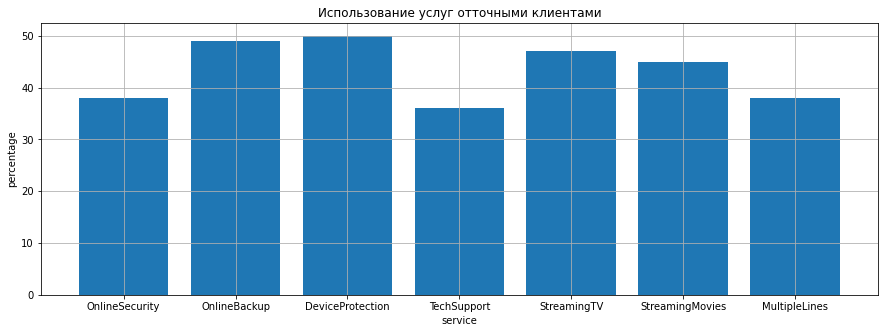

In [58]:
fig = plt.figure(figsize = (15, 5))

plt.bar(services, outflow_services)

plt.title("Использование услуг отточными клиентами")

plt.xlabel('service')
plt.ylabel('percentage')
plt.grid(True)
 
plt.show()

Уже видны значительные различия. Клиенты, разорвавшие контракты с нашим оператором связи, более активно пользовались дополнительными сервисами. Особенно выделяются: **OnlineBackup**, **DeviceProtection**, **StreamingTV**, **StreamingMovies**. \
Последние два пункта были и у лояльных клиентов, в отличие от **первого и второго**. Поэтому можно сделать предположение, что именно из-за этих пунктов компания теряет пользователей. \
Теперь покажем статистику по **персональным данным**.

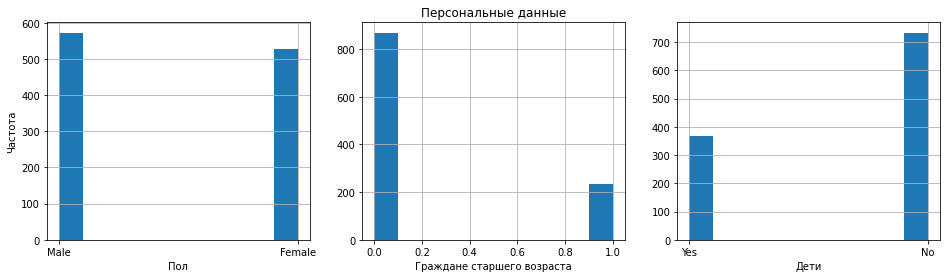

In [59]:
plt.figure(figsize=(16, 4))


plt.subplot(131)
plt.grid(True)
plt.xlabel('Пол')
plt.ylabel('Частота')
plt.hist(outflow['gender'])


plt.subplot(132)
plt.grid(True)
plt.xlabel('Граждане старшего возраста')
# plt.ylabel('Частота')
plt.hist(outflow['SeniorCitizen'])

plt.title('Персональные данные')

plt.subplot(133)
plt.grid(True)
plt.xlabel('Дети')
# plt.ylabel('Частота')
plt.hist(outflow['Dependents'])

plt.show()

Мужчин **незначительно больше**, **доля** пенсионеров **такая же**, а граждан **без детей в 2 раза больше**, чем с ними. \
Исходя из этого никаких выводов сделать, увы, не получится. \
Взглянем на типы контрактов.

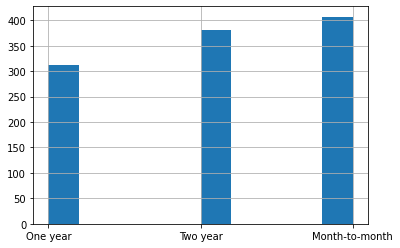

In [60]:
outflow['Type'].hist();

Здесь число всех контрактов примерно одинаковое.

In [61]:
outflow.groupby(['Type'])['duration'].mean()

Type
Month-to-month     751.331695
One year           954.099042
Two year          1086.220472
Name: duration, dtype: float64

Средняя длительность пользования услугами оператора **выше у месячных договоров**, но **ниже у остальных**.

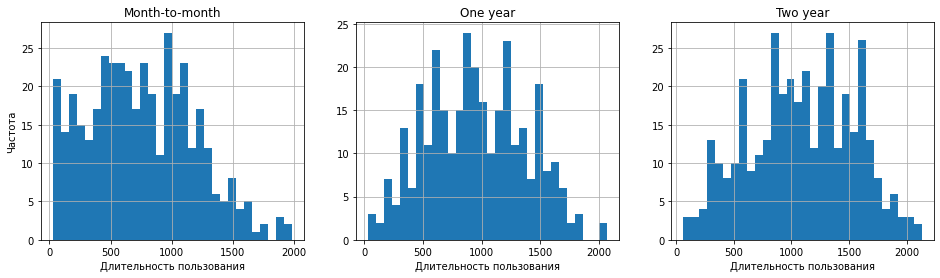

In [62]:
plt.figure(figsize=(16, 4))


plt.subplot(131)
plt.grid(True)
plt.title('Month-to-month')
plt.xlabel('Длительность пользования')
plt.ylabel('Частота')
plt.hist(outflow.query('Type == "Month-to-month"')['duration'], bins=30)

plt.subplot(132)
plt.grid(True)
plt.title('One year')
plt.xlabel('Длительность пользования')
# plt.ylabel('Частота')
plt.hist(outflow.query('Type == "One year"')['duration'], bins=30)

plt.subplot(133)
plt.grid(True)
plt.title('Two year')
plt.xlabel('Длительность пользования')
# plt.ylabel('Частота')
plt.hist(outflow.query('Type == "Two year"')['duration'], bins=30)

plt.show()

У **одно-** и **двухгодовых** контрактов графики одинаковые (на обоих преобладают клиенты со сроком пользования **от 500 до 1000 дней**). В случае с **месячными договорами** всё также, но **побольше новых пользователей**.

Теперь рассмотрим ещё один параметр: количество уходов в течении времени.

In [63]:
# изменим тип данных
outflow.loc[:, 'EndDate'] = pd.to_datetime(outflow.loc[:, 'EndDate'])

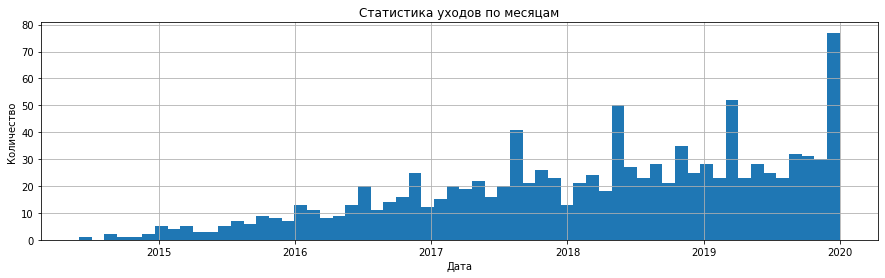

In [64]:
# нарисуем график
month_outflow = outflow['EndDate'].dt.normalize()

plt.title('Статистика уходов по месяцам')
plt.xlabel('Дата')
plt.ylabel('Количество')

month_outflow.hist(figsize=(15, 4), bins=60);

С каждым годом уходов всё больше. Также присутствует несколько пиковых моментов, когда компания теряет больше клиентов, чем обычно. Однако вполне возможно, что это компенсируется приходом новых. Давайте проверим это.

In [65]:
new_clients = df_all['BeginDate']
new_clients = new_clients.dt.normalize()

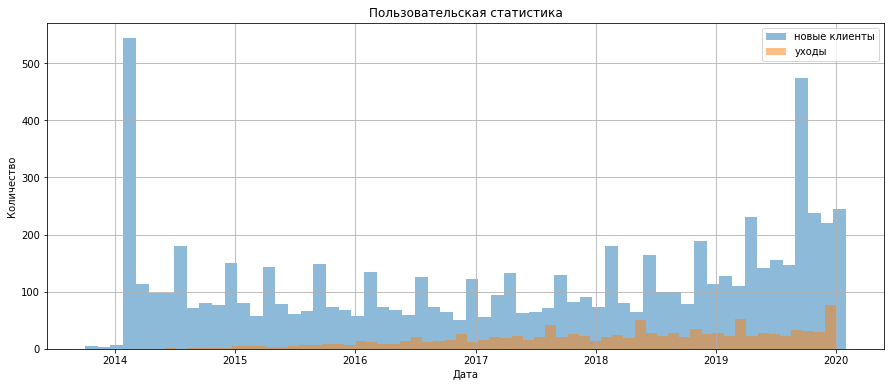

In [66]:
plt.figure(figsize=(15, 6))

plt.title('Пользовательская статистика')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid(True)

plt.hist(new_clients, bins=60, alpha = 0.5, label='новые клиенты');
plt.hist(month_outflow, bins=60, alpha = 0.5, label='уходы');

plt.legend(loc='upper right')
plt.show()

Здесь всё уже не так плачевно. Число уходов действительно учеличилось, но новые контракты компенсируют потери. 

### Корреляция признаков

Теперь с помощью библиотеки **phik** построим корреляционную матрицу.

In [67]:
phik_corr = df_all.drop(['customerID', 'BeginDate', 'EndDate'], axis=1).phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'leaving', 'duration']


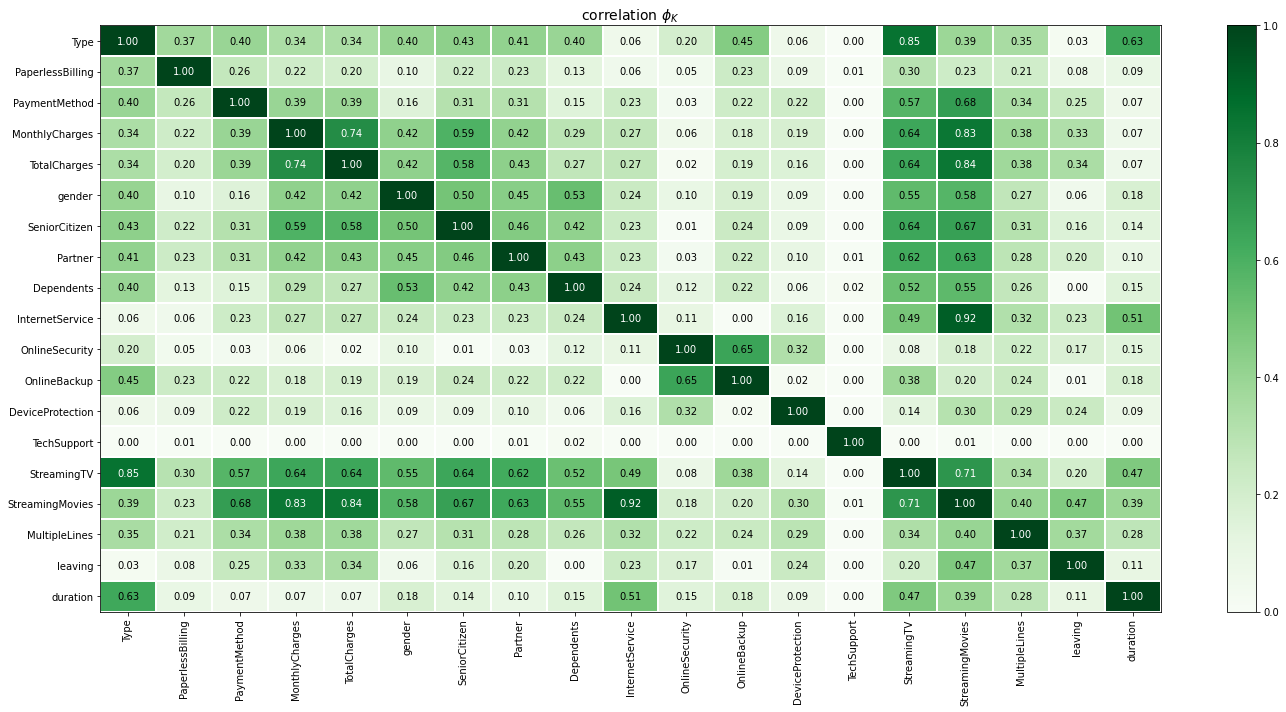

In [68]:
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns[::-1],
                        y_labels=phik_corr.index[::-1],
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        figsize=(20, 10))

На этой таблице можно увидеть много скрытых взаимосвязей между признаками: например, стриминговые сервисы влияют на размер ежемесячной платы. Взаимосвязаны также и некоторые сервисы. Высоких коэффициентов корреляции **с целевым признаком** нет ни у кого.

### Вывод по EDA

Мы рассмотрели много параметров, разделив данные на классы клиентов (**лояльные** и **отточные**). **Отобразили признаки на графиках** и сделали всевозможные выводы касаемо того, что **влияет на отказ пользователя от услуг** нашего оператора связи. Также было сделано **предположение** о том, что клиенты **недовольны дополнительными сервисами**, так как среди **отточных** клиентов был замечен **повышенный интерес** ко многим из них. \
Перейдём к **подготовке признаков** для обучения моделей.

## Подготовка признаков

### Разделение на выборки

Выделим **целевой признак** и выкинем **избыточные признаки**: **customerID**, **BeginDate**, **EndDate**.

In [70]:
features = df_all.drop(['customerID', 'BeginDate', 'EndDate', 'leaving'], axis=1)
target = df_all['leaving']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

Проверим корректность разбиения:

In [69]:
print('Размер обучающей выборки:', len(features_train), 'или', len(features_train) / len(df_all) * 100, '%')
print('Размер тестовой выборки:', len(features_test), 'или', len(features_test) / len(df_all) * 100, '%')

Размер обучающей выборки: 5282 или 74.99645037626011 %
Размер тестовой выборки: 1761 или 25.003549623739886 %


Выделим категориальные и численные признаки для кодирования и масштабирования перед обучением моделей:

In [70]:
# категориальные признаки
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [71]:
#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

# 'SeniorCitizen' — категориальный бинарный признак.
num_features.remove('SeniorCitizen') 
num_features

['MonthlyCharges', 'TotalCharges', 'duration']

Наконец, перейдём к делу.

## Обучение моделей

### Логистическая регрессия

Выполним кодирование и масштабирование, а также перебор гиперпараметров модели логистической регрессии, используя **make_column_transformer** и **make_pipeline**.

In [72]:
features_train_lr = features_train.copy()
features_test_lr = features_test.copy()

In [73]:
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

In [125]:
%%time

model_lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

pipeline_lr = make_pipeline(col_transformer_lr, model_lr)

param_grid_lr = {
    'logisticregression__solver': ['lbfgs', 'liblinear'],
    'logisticregression__max_iter': [50, 100, 150]
}

gs_lr = GridSearchCV(
    pipeline_lr, 
    param_grid=param_grid_lr, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_lr.fit(features_train_lr, target_train)


gs_lr_best_score = gs_lr.best_score_
gs_lr_best_params = gs_lr.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_lr_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_lr_best_params}')

best_score: 0.7696108127217427
best_params: {'logisticregression__max_iter': 50, 'logisticregression__solver': 'lbfgs'}
CPU times: user 8.12 s, sys: 14 s, total: 22.2 s
Wall time: 22.2 s


Для первой модели результат хороший, попробуем его улучшить.

### Случайный лес

Здесь будем действовать также, но не будем применять масштабирование.

In [75]:
features_train_rf = features_train.copy()
features_test_rf = features_test.copy()

In [82]:
%%time

col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(1, 16),
    'randomforestclassifier__min_samples_split': range(1, 6),
    'randomforestclassifier__min_samples_leaf': range(1, 6)
}

gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_rf.fit(features_train_rf, target_train)

gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.819788870267196
best_params: {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_depth': 11}
CPU times: user 29.8 s, sys: 162 ms, total: 30 s
Wall time: 30.1 s


Теперь перейдём к бустингу.

### Градиентный бустинг

Обучим модель на исходных признаках, так как CatBoostClassifier работает с категориальными переменными напрямую.

In [88]:
%%time

model_cat = CatBoostClassifier(auto_class_weights='Balanced', random_state=RANDOM_STATE)

param_grid_cat = {
    'iterations': [500, 750],
    'depth': [5, 10],
    'learning_rate': [0.05, 0.1]
}

gs_cat = GridSearchCV(
    model_cat,
    param_grid=param_grid_cat, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_cat.fit(features_train, target_train, cat_features=ohe_features, verbose=250)

gs_cat_best_score = gs_cat.best_score_
gs_cat_best_params = gs_cat.best_params_
print(f'best_score: {gs_cat_best_score}')
print(f'best_params: {gs_cat_best_params}')

0:	learn: 0.6794997	total: 10.5ms	remaining: 5.24s
250:	learn: 0.3965062	total: 1.83s	remaining: 1.81s
499:	learn: 0.2949555	total: 3.59s	remaining: 0us
0:	learn: 0.6769341	total: 9.29ms	remaining: 4.64s
250:	learn: 0.3918772	total: 1.59s	remaining: 1.58s
499:	learn: 0.2847081	total: 3.37s	remaining: 0us
0:	learn: 0.6765698	total: 5.71ms	remaining: 2.85s
250:	learn: 0.4089652	total: 1.46s	remaining: 1.45s
499:	learn: 0.2950718	total: 3.21s	remaining: 0us
0:	learn: 0.6779007	total: 10.2ms	remaining: 5.11s
250:	learn: 0.4057871	total: 1.9s	remaining: 1.88s
499:	learn: 0.2950074	total: 4.05s	remaining: 0us
0:	learn: 0.6774274	total: 6.5ms	remaining: 3.25s
250:	learn: 0.4012448	total: 1.57s	remaining: 1.55s
499:	learn: 0.2980954	total: 3.2s	remaining: 0us
0:	learn: 0.6667330	total: 9.7ms	remaining: 4.84s
250:	learn: 0.2855283	total: 1.68s	remaining: 1.67s
499:	learn: 0.1767586	total: 3.28s	remaining: 0us
0:	learn: 0.6618294	total: 6.18ms	remaining: 3.08s
250:	learn: 0.2780974	total: 1.62s	

Необходимая граница метрики AUC-ROC достигнута!

### Результаты

Запишем получившиеся результаты в таблицу.

In [90]:
result = pd.DataFrame(
    [gs_lr_best_score, gs_rf_best_score, gs_cat_best_score], 
    index=['LogisticRegression', 'RandomForestRegressor', 'CatBoostClassifier'], 
    columns=['AUC-ROC']
)
result

,AUC-ROC
LogisticRegression,0.769611
RandomForestRegressor,0.819789
CatBoostClassifier,0.895116


Таким образом самой лучшей оказалась модель градиентного бустинга **CatBoostClassifier**. Значение AUC-ROC на тренировочных данных для неё составило **0.895116**.

## Проверка лучшей модели на тестовой выборке

Вычислим метрику AUC-ROC на тестовых данных.

In [115]:
cat_test_result = roc_auc_score(target_test, gs_cat.predict_proba(features_test)[:, 1])
print('Метрика на тесте:', cat_test_result)
print('Отличие от тренировочной:', cat_test_result - gs_cat_best_score)

Метрика на тесте: 0.9111721075489192
Отличие от тренировочной: 0.016055612923206897


Результат отличный! Но сделаем ещё пару вещей. \
Изучим лучшую модель подробнее:
1. Покажем важность признаков
2. Построим ROC-кривую
3. Выведем матрицу ошибок

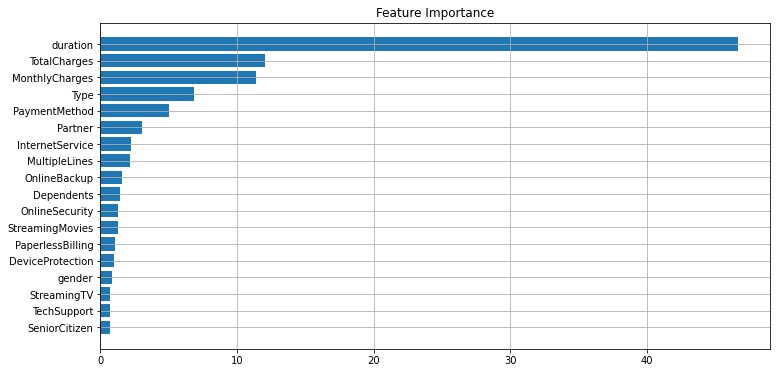

In [102]:
feature_importance = gs_cat.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.grid(True)

plt.show()

CatBoostClassifier: ROC AUC=0.911


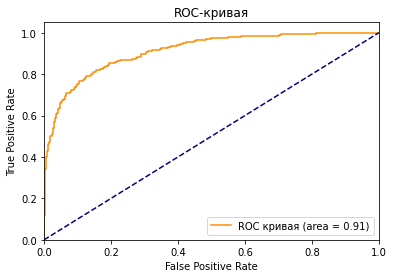

In [116]:
# получаем предказания
lr_probs = gs_cat.predict_proba(features_test)

# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]

# рассчитываем ROC AUC
lr_auc = roc_auc_score(target_test, lr_probs)
print('CatBoostClassifier: ROC AUC=%.3f' % (lr_auc))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, lr_probs)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

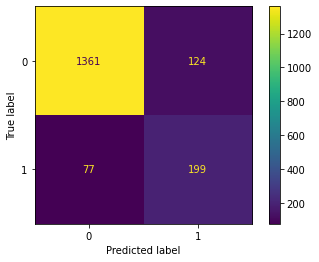

In [124]:
cm = confusion_matrix(target_test, gs_cat.predict(features_test), labels=gs_cat.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs_cat.classes_)
disp.plot()
plt.show()

Как оказалось наибольшую важность имеет признак **duration**, затем идут параметры, связанные с **оплатой**. А вот **дополнительные сервисы** почти ни на что не влияют.

## Вывод

Мы провели подробное исследование, в ходе которого сделали следующее:
- Изучили данные в исходных файлах.
- Объединили их и провели предобработку, сгенерировали новые признаки (в том числе целевой).
- Провели EDA и сделали предположения по поводу влияния характеристик на уход клиента.
- Разделили данные на выборки
- Обучили 3 модели (для некоторых провели кодирование и масштабирование признаков).
- По результатам обучения лучшей была выбрана модель CatBoostClassifier с метрикой **0.89**. На тесте же она увеличилась до **0.91**. Также были показаны характеристики итоговой модели.